# Motivation

Similar to K-nearest neighbours, kernel regression makes the assumption that if two examples have similar features, then they're likely to have similar targets/labels as well. Whilst K-nearest neighbours averages the targets of the K nearest examples, in kernel regression we account for the targets of all points in the training set, weighting the contribution of each example based on how close it is to the example we're trying to predict for.

For example, let's say we were trying to make predictions based off a single feature and the example we were trying to make a prediction for had the feature $x^* = 10$. Suppose that for each example in our training set we computed the distance $d_i = |x_i - 10|, i = 1,..., n$ and we found that the two closest examples in the training set were $(x = 9, y = 20), (x = 21, y = 45)$.

Under K-nearest neighbours, we would weight the contributions of these two examples equally when making our prediction (unless K=1). Conversely, using kernel regression we would say that since the point with $x = 9$ is much more relevant to the example we're trying to predict because the feature value is much closer to $x^* = 10$ and so it should be accorded more importance when making our prediction.

# How exactly do we weight each example?

Writing what we discussed above slightly more formally, if we have a training dataset $D = (x_1, y_1), ..., (x_n, y_n)$, then for a new example with features $x^*$, we predict the associated label to be:

$$y^* = \frac{\sum_{i=1}^n \omega_i \times y_i}{\sum_{i=1}^n \omega_i}$$

Where $\omega_i$ is a function of $||x_i - x^*||$, the distance between the feature vector for the $i^{th}$ training example and the feature vector of our new example. We want $\omega_i$ to follow two rules:

1. As $||x_i - x^*||$ increases, $\omega_i$ should monotonically decrease (the further away a point is, the less weight it should have)
2. $\omega_i > 0, i = 1,...,n$ - we can't have zero or negative weights

There are lots of different functions we could use to meet that fulfil these criteria but the most widely used one is known as the Gaussian kernel, where we set:

$$\omega_i = k(x_i, x^*) = \text{exp}(\frac{-||x_i - x^*||^2}{2h^2})$$

In the 1-dimensional case, this function has the same squared exponential term as a gaussian distribution and so we can think of the weights following that bell-shaped pattern, centered around $x^*$. Note that the weights associated with each training example change as we make predictions for different inputs.

Finally, you might be wondering about the $h$ in denominator of the exponential term - this is a hyperparameter of our model called the 'bandwidth' which governs exactly how much we penalise terms from being far away from $x^*$. If $h$ is very large, then the model will prioritise points close to $x^*$ to a much greater degree than it would if $h$ was small. At the end of this notebook we take a look at what happens if we tweak the value of $h$ and discuss how we can pick the best value. 

# Data Generation 

In [1]:
#Import modules
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### As with K-nearest neighbours, this kind of kernel regression works exactly the same for a single feature dataset as it does for a higher-dimensional one so we'll use a single feature dataset for easier visualisation

We're going to use the same dataset for this exercise as we did for the K-nearest neighbours implementation. If you aren't familiar with K-nearest neighbours yet, we'd recommend tackling those notebooks before moving onto this one!

In [2]:
n = 200 #Number of observations
X = np.random.uniform(0,5,n)
Y = np.array([x*np.sin(x**2) for x in X]) + np.random.normal(0,1,n)

data = pd.DataFrame({'X':X, 'Y':Y})

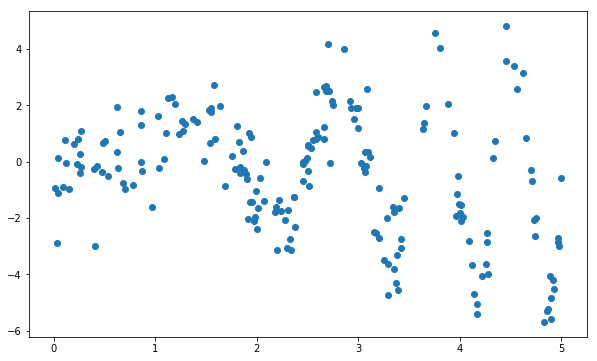

In [3]:
plt.figure(figsize = (10,6))
plt.scatter(X,Y)
plt.show()

In [4]:
class kernelRegression:
    
    def __init__(self, data, target, features, trainTestRatio = 0.9):
        
        self.target = target
        self.features = features 
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio)
       
    #There's no fitting process for kernel regression, per se. To make predictions we simply examine the training set
    #and find the closest examples we can
    
    
    def kernelFunction(self, x, h):
        
        return np.exp(-np.linalg.norm(x)**2/(2*h**2))
    
    def predictSingleExample(self, x, h = 0.1):
        
        
        #Apply kernel smoother to get the weight of each training example
        weights = [self.kernelFunction(np.array(x) - np.array(row[self.features]), h) for idx, row in self.train.iterrows()]
        
        #Return weighted, normalised sum
        return np.dot(weights, self.train[self.target])/np.sum(weights)
        
        
    
    def predict(self, X = None, h = 0.1):
        #Predict the values for a dataframe of values (in the same format as the training set)
        #Returns a list of the predicted values
        
        #if no X provided, predict values of the test set
        if X is None:
            X = self.test
        
        return [self.predictSingleExample(x, h) for idx, x in X.iterrows()]
        
        
        
        
        

# Now let's predict on the test set

In [5]:
myKR = kernelRegression(data, 'Y', ['X'])

In [6]:
myKR.test['Pred'] = myKR.predict(h = 0.05)

/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Plot the results

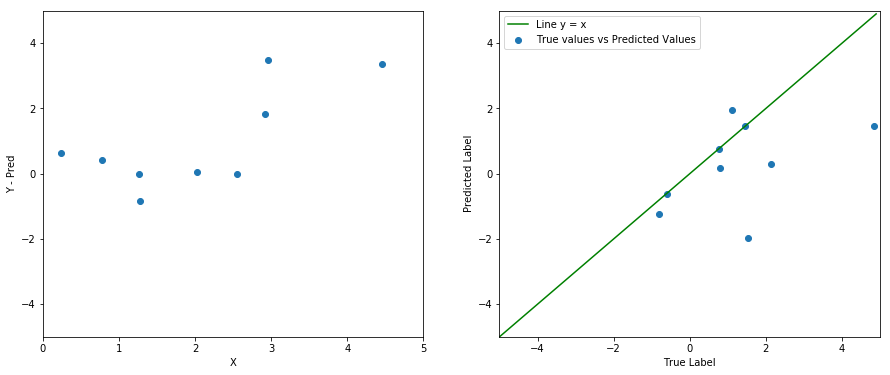

In [7]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.scatter(myKR.test['X'], myKR.test['Y'] - myKR.test['Pred'])
ax.set_xlabel('X')
ax.set_ylabel('Y - Pred')
ax.set_xlim([0, 5])
ax.set_ylim([-5,5])

ax2.scatter(myKR.test['Y'], myKR.test['Pred'], label = 'True values vs Predicted Values')
ax2.plot(np.arange(-5,5,0.1), np.arange(-5,5,0.1), color = 'green', label = 'Line y = x')
ax2.set_xlim([-5, 5])
ax2.set_ylim([-5,5])
ax2.set_xlabel('True Label')
ax2.set_ylabel('Predicted Label')
ax2.legend()

plt.show()



The left plot shows the residuals plotted against out input feature, X. We can see that overall, the residuals are scattered about 0, indicating that in general the model did a decent job of capturing the relationship between the feature and target. The residuals exhibit slighly more variance when $x > 3$, but this is not particularly surpising as the target oscillates for large $x$.

If we examine the plot on the right, we can see that the scatter plot of the true vs predicted values generally adheres to the line line $y = x$, indicating the model is performing as we would want.


# Examining the effect of changing h

h is a hyperparameter we can tune and should be thought of as a regulariser. The larger the value of k, the more training examples we use in the prediction and therefore the model will be more robust to slight perturbations as we increase k.

Let's plot the regression line for a variety of different values of h


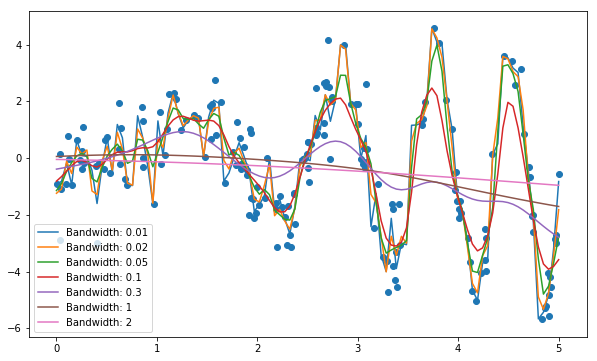

In [8]:
plt.figure(figsize = (10,6))

dataRegLine = pd.DataFrame({'X':np.linspace(0,5,100)})

for h in [0.01, 0.02, 0.05, 0.1, 0.3, 1, 2]:
    
    dataRegLine[f'Pred{h}'] = myKR.predict(X = dataRegLine[['X']], h = h) #Obtain predictions
    plt.plot(dataRegLine['X'], dataRegLine[f'Pred{h}'], label = f'Bandwidth: {h}') #Plot regression line
    
plt.legend()

plt.scatter(myKR.train['X'], myKR.train['Y'])
plt.show()
    
    

The plot above shows the effect of changing the value of h. As we said at the top of this notebook, small bandwidths mean that we give much more weight to the values which are close to the point of interest than those which are far away. This leads to a much more flexible regression line as the predictions change dramtically as we move along the x-axis and different examples become much more important to our predictions. When h is larger, we still give more weight to a point that is close than one that is far away, but the ratio of these different weights is dramatically reduced, hence the much more stable predictions.

## How do we choose the best bandwidth?

Hyperparameter tuning is a central part of machine learning, and worth studying in depth on its own! Nevertheless, a common way of selecting an appropriate bandwidth is often to use k-fold cross validation. Suppose there are $k=5$ different bandwidths that we want to test; we can split our training set into 5 different subsets (also called folds). We take the first subset and examine the performance of our model when we use the first hyperparameter and the other 80\% of our data to train it, using the first subset as our testing set. Next, we take the second subset, which acts as a testing set for the model we trained using the second hyperparameter and subsets 1,3,4 \& 5. We continue this process until we have a score for each of the hyperparameters under consideration, and select the hyperparameter which gave the best performance. 

Note that throughout the cross-validation process that our original testing set should not have been touched! The test sets used during the cross-validation are also part of the training sets and using our real test set to guide hyperparamter selection is cheating!

## Qualitative factors in bandwidth selection

Inspecting the different regression lines in the figure above, we can probably conclude that we'd be fairly disappointed with the one corresponding to a bandwidth of 2; it's effectively just a straight line and fails to capture the non-linear relationship between features and target. Conversely, the smaller bandwidths do a lot better in terms of predictive accuracy. However, small bandwidths make our models more sensitive to slight perturbations in individual observations, meaning that if there is some source of noise in our data capturing or our dataset is not particularly large we can end up making inaccurate predictions as our predictions rely heavily on a small number of points. As a general heuristic, then, if we have a small, messy dataset we should choose larger bandwidth values, whereas if we have a large, trustworthy dataset then we're able to choose smaller bandwidths and allow our models to fluctuate more.